In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import utility as ult

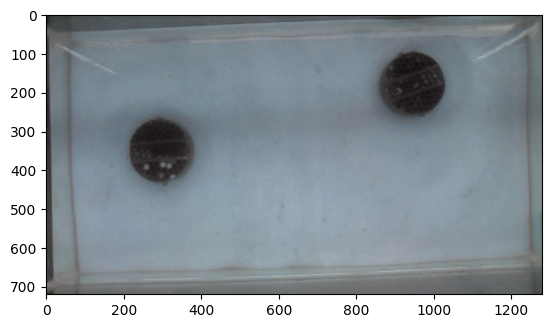

In [23]:
# Background Processing
cap = cv.VideoCapture("Video1.mp4")
rt, bg = cap.read()
cv.imwrite("bg.jpg", bg)

background = cv.imread("bg.jpg")
plt.imshow(background)


In [101]:
# Video Clip, 50s
cap = cv.VideoCapture('video2.mp4')
cap.set(cv.CAP_PROP_POS_MSEC, 0)

# 30s in miliseconds
duration = 65000

ret, frame = cap.read()
size = (frame.shape[1], frame.shape[0])
out = cv.VideoWriter("Video2_Clip.avi", cv.VideoWriter_fourcc(*'MJPG'), 29, size)

# Read frames from the video until the end of the clip is reached
while ret:
    if not ret or cap.get(cv.CAP_PROP_POS_MSEC) >= duration:
        break
    out.write(frame)

    ret, frame = cap.read()

cap.release()
out.release()


# Circle Detection

In [28]:
# Burrow Detection
grayBackground = cv.cvtColor(background, cv.COLOR_BGR2GRAY)
grayBackground = cv.GaussianBlur(grayBackground, (7, 7), 0) 

BGCircles = ult.BurrowDetection(grayBackground)
BGCircles

array([[946, 180,  84],
       [294, 356,  78]])

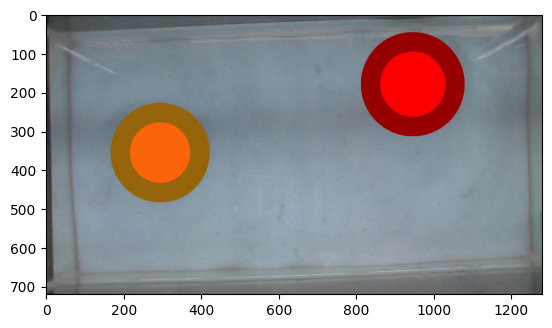

In [29]:
for i in range(len(BGCircles)):
    cv.circle(background, (BGCircles[i][0], BGCircles[i][1]), BGCircles[i][2]+50, (150, 100*i, 10*i), -1)
    cv.circle(background, (BGCircles[i][0], BGCircles[i][1]), BGCircles[i][2], (250, 100*i, 10*i), -1)

plt.imshow(background)

In [30]:
centers = []
radius = []
for i in range(len(BGCircles)):
    centers.append((BGCircles[i][0], BGCircles[i][1]))
    radius.append(BGCircles[i][2])

# Tracking

## Background Subtraction

In [109]:
def BackgroundSubtraction(video, back):
    background = cv.imread(back)
    capture = cv.VideoCapture(video)

    ret, frame = capture.read()

    size = (frame.shape[1], frame.shape[0])

    # Convert background to required format
    background = cv.resize(background, size)
    #grayBackground = cv.GaussianBlur(background, (55,55),0)
    grayBackground = cv.cvtColor(background, cv.COLOR_RGB2GRAY)
    
    processed = []
    out = cv.VideoWriter("BlackWhiteResult.avi", cv.VideoWriter_fourcc(*'MJPG'), 29, size)

    while ret:

        # Convert frame to required format
        #grayFrame = cv.GaussianBlur(frame, (55,55),0)
        grayFrame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)

        # Subtract the background
        delta = cv.absdiff(grayBackground, grayFrame)

        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (10, 10))
        opened = cv.morphologyEx(delta, cv.MORPH_OPEN, kernel)

        blur = cv.GaussianBlur(opened, (23, 23), 0)

        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (60, 60))
        closed = cv.morphologyEx(blur, cv.MORPH_CLOSE, kernel)
        
        threshold = cv.threshold(closed, 135, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)[1]

        #Record the processed image
        processed.append(threshold)

        RGBMode = cv.cvtColor(threshold, cv.COLOR_GRAY2RGB)
        out.write(RGBMode)

        ret, frame = capture.read()

    capture.release()
    out.release()

    return processed

In [103]:
processed = BackgroundSubtraction("Video2_Clip.avi", "bg.jpg")

## Tractor

In [158]:
import pandas as pd
import tracktor as tr

In [162]:
def detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area = 0, max_area = 10000):
    """
    This function detects contours, thresholds them based on area and draws them.
    
    Parameters
    ----------
    frame: ndarray, shape(n_rows, n_cols, 3)
        source image containing all three colour channels
    thresh: ndarray, shape(n_rows, n_cols, 1)
        binarised(0,255) image
    meas_last: array_like, dtype=float
        individual's location on previous frame
    meas_now: array_like, dtype=float
        individual's location on current frame
    min_area: int
        minimum area threhold used to detect the object of interest
    max_area: int
        maximum area threhold used to detect the object of interest
        
    Returns
    -------
    final: ndarray, shape(n_rows, n_cols, 3)
        final output image composed of the input frame with object contours 
        and centroids overlaid on it
    contours: list
        a list of all detected contours that pass the area based threhold criterion
    meas_last: array_like, dtype=float
        individual's location on previous frame
    meas_now: array_like, dtype=float
        individual's location on current frame
    """
    # Detect contours and draw them based on specified area thresholds
    if int(cv.__version__[0]) == 3:
        img, contours, hierarchy = cv.findContours(thresh.copy(), cv.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    else:
        contours, hierarchy = cv.findContours(thresh.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    final = frame.copy()

    i = 0
    meas_last = meas_now.copy()
    del meas_now[:]
    while i < len(contours):
        area = cv.contourArea(contours[i])
        if area < min_area or area > max_area:
            contours = contours[:i] + contours[i+1:]
        else:
            mts = cv.moments(contours[i])
            if mts['m00'] != 0:
                cx = int(mts["m10"] / mts["m00"])
                cy = int(mts["m01"] / mts["m00"])
            else:
                cx = 0 
                cy = 0
            meas_now.append([cx,cy])
            i += 1
    return final, contours, meas_last, meas_now

In [139]:
n_inds = 1
t_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]
scaling = 1.0

min_area = 100
max_area = 99999

In [198]:
capture = cv.VideoCapture("Video2_Clip.avi")

out = cv.VideoWriter("Tracked.avi", cv.VideoWriter_fourcc(*'MJPG'), 29, size)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

df = []
last = 0

ret, frame = capture.read()
while ret:
    
    this = capture.get(1)
    frame = cv.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv.INTER_LINEAR)
    thresh = processed[int(this-1)]
    final, contours, meas_last, meas_now = detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)
    if len(meas_now) != n_inds:
        contours, meas_now = tr.apply_k_means(contours, n_inds, meas_now)
        
    row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
    final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, True, this)
        
    # Create output dataframe
    for i in range(n_inds):
        df.append([this, meas_now[i][0], meas_now[i][1], t_id[i]])


    for i in range(len(centers)):
        cv.circle(final, centers[i], radius[i], (255-50*i, 255, 50*i), 5)
        df.append([this, centers[i][0], centers[i][1], "Burrow {}".format(i+1)])
        
    # Display the resulting frame
    out.write(final)

    if last >= this:
        break
    
    last = this

    ret, frame = capture.read()

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y', 'id'])

## When everything done, release the capture
cap.release()
out.release()

c:\Users\brian\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [199]:
df.to_csv("tracking.csv", sep = ",")

In [200]:
df

,frame,pos_x,pos_y,id
0,1.0,374,404,A
1,1.0,946,180,Burrow 1
2,1.0,294,356,Burrow 2
3,2.0,375,404,A
4,2.0,946,180,Burrow 1
...,...,...,...,...
5842,1948.0,946,180,Burrow 1
5843,1948.0,294,356,Burrow 2
5844,1949.0,362,272,A
5845,1949.0,946,180,Burrow 1
